## Model_1: Model with Sentiment Classification Model

Set up a basic pipeline using **standardized preprocessing from preprocess.py** and distilbert.

🔧 Steps:
1. Import Libraries and load data using **preprocess.py functions**
2. Preprocessing: refer data_preprocessing.ipynb notebook
3. Vectorization: DistilBertTokenizer
4. Model: distilbert
5. Evaluation: Accuracy, confusion matrix, classification report

✅ Purpose:
Establish a working pipeline using **standardized preprocessing functions** and maintain baseline score (~70-80% accuracy expected).

## Step1: Import Libraries and read cleaned Data 

In [3]:
%pip install --no-cache-dir torch transformers==4.52.3 datasets scikit-learn pandas matplotlib seaborn accelerate>=0.26.0

zsh:1: 0.26.0 not found
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-13 11:11:54.254730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

## Step 2: Load and Verify Cleaned Data

In [ ]:
df = pd.read_csv("data/cleaned_amazon_reviews_final.csv")
print(df.head())

                                                name       asins   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   

                                          categories primaryCategories  \
0  Computers,Electronics Features,Tablets,Electro...       Electronics   
1  Computers,Electronics Features,Tablets,Electro...       Electronics   
2  Computers,Electronics Features,Tablets,Electro...       Electronics   
3  Computers,Electronics Features,Tablets,Electro...       Electronics   
4  Computers,Electronics Features,Tablets,Electro...       Electronics   

                                           imageURLs doRecommend  rating  \
0  https://pisces.bbys

In [ ]:
try:
    df = pd.read_csv('data/cleaned_amazon_reviews_final.csv')
    if 'clean_text' not in df.columns or 'label' not in df.columns:
        raise KeyError("Required columns 'clean_text' and 'label' not found in dataset.")
    df = df[['clean_text', 'label']].dropna()
    if df.empty:
        raise ValueError('DataFrame is empty after filtering! Check data loading and file path.')
    if not all(df['label'].apply(lambda x: isinstance(x, (int, np.integer)))):
        raise ValueError("label must be integers (e.g., 1, 2, 3, 4, 5). Check 'label' column.")
    
    # Encode ratings
    label_encoder = LabelEncoder()
    df['encoded_rating'] = label_encoder.fit_transform(df['label'])
    print("Dataset Head:\n", df.head())
    print("\nColumn Names:\n", df.columns)
    print("\nUnique label:\n", df['label'].unique())
    print(f"Encoded label classes: {label_encoder.classes_}")
except FileNotFoundError:
    print("Error: 'data/cleaned_amazon_reviews_final.csv' not found. Verify file path.")
    raise
except KeyError as e:
    print(f"Error: {e}")
    raise
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Dataset Head:
                                           clean_text  label  encoded_rating
0  too small i thought it would be as big as smal...      1               1
1  great light reader easy to use at the beach th...      2               2
2  great for the price didnt know how much id use...      2               2
3  a great buy i am happy with my purchase i caug...      2               2
4  solid entrylevel kindle great for kids solid e...      2               2

Column Names:
 Index(['clean_text', 'label', 'encoded_rating'], dtype='object')

Unique label:
 [1 2 0]
Encoded label classes: [0 1 2]


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])

LabelEncoder()

## Step 3: Train, Test, Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'].tolist(),
    df['encoded_rating'].tolist(),
    test_size=0.2,
    random_state=42
)
# Map 'rating' to 'labels' for Trainer compatibility
train_dataset = Dataset.from_dict({'text': X_train, 'labels': y_train})
val_dataset = Dataset.from_dict({'text': X_test, 'labels': y_test})

## Step 4: Vectorization with DistilBERT Tokenizer 

In [ ]:
try:
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)
    
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    
    # Set format for torch
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    
    # Debug: Verify dataset format
    print("\nTraining dataset columns:", train_dataset.column_names)
    print("Sample training data:", {k: v for k, v in train_dataset[0].items()})
except Exception as e:
    print(f"Error during tokenization: {e}")
    raise

Map:   0%|          | 0/16050 [00:00<?, ? examples/s]

Map:   0%|          | 0/4013 [00:00<?, ? examples/s]


Training dataset columns: ['text', 'labels', 'input_ids', 'attention_mask']
Sample training data: {'labels': tensor(2), 'input_ids': tensor([ 101, 2274, 3340, 2307, 3976, 1998, 2613, 8875,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attenti

## Step 5: Model Setup

In [ ]:
try:
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(label_encoder.classes_)  # Number of unique ratings
    )
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy'
    )
    
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, predictions)
        return {'accuracy': acc}
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
except Exception as e:
    print(f"Error during model setup: {e}")
    raise

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step 6: Model Training and Evaluation

In [ ]:
try:
    print("Starting model training...")
    trainer.train()
    print("Training completed.")
    
    eval_results = trainer.evaluate()
    print('Evaluation Results:', eval_results)
    
    predictions = trainer.predict(val_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = np.array(val_dataset['labels'])  # Use 'labels' from dataset
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_.astype(str)))
except Exception as e:
    print(f"Error during training or evaluation: {e}")
    raise

Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.056100,0.200379,0.949664
2,0.214700,0.183409,0.952903
3,0.034400,0.203316,0.951408


Training completed.


Evaluation Results: {'eval_loss': 0.18340949714183807, 'eval_accuracy': 0.9529030650386244, 'eval_runtime': 351.3883, 'eval_samples_per_second': 11.42, 'eval_steps_per_second': 1.429, 'epoch': 3.0}
Validation Accuracy: 0.9529

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       240
           1       0.62      0.36      0.45       177
           2       0.98      0.99      0.98      3596

    accuracy                           0.95      4013
   macro avg       0.79      0.74      0.75      4013
weighted avg       0.95      0.95      0.95      4013



C:\Users\Mercy\AppData\Local\Temp\ipykernel_27644\1697195683.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_true = np.array(val_dataset['labels'])  # Use 'labels' from dataset


## Step 7: Confusion Matrix

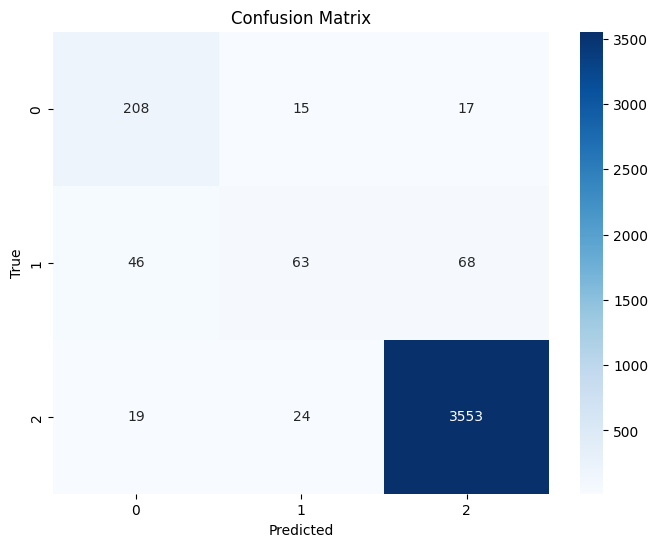

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()